# 04.04 - Modeling
+ Imports & Setup
+ Encode 'city' column via LeaveOneOutEncoder
+ Train Models with Defaul Settings
 + Select Models
 + Compare Results
+ Apply SMOTE to oversample data
+ Re-train Models Based on New Dataset (Oversampled Data)
 + Compare Results 
 + Tune Hyperparameters for Outperformed Models 
+ Choose Final Model

## Imports & Setup

In [316]:
import os
import pandas as pd
# import datetime
import seaborn as sns
sns.set()
import matplotlib.pyplot as plt
import numpy as np
# from scipy import stats
# import random
from category_encoders import LeaveOneOutEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split 
from sklearn.model_selection import KFold
from sklearn import model_selection

from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
import xgboost as xgb
#from catboost import CatBoostClassifier
import lightgbm as lgb

import time
from sklearn import metrics
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_recall_fscore_support as score, accuracy_score
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from imblearn.over_sampling import SMOTE
%matplotlib inline

In [317]:
print(os.getcwd())
os.chdir('/Users/liuyang/Desktop/Springboard_Capstone') 
print(os.getcwd())

/Users/liuyang/Desktop/Springboard_Capstone
/Users/liuyang/Desktop/Springboard_Capstone


In [318]:
df = pd.read_csv('data/preprocessed_train.csv')

In [319]:
df.head()

,city,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,training_hours,target
0,city_149,0.689,1,1,0,2,1,1,2,4,1,106,0
1,city_83,0.923,1,1,0,2,1,3,1,2,1,69,0
2,city_16,0.910,1,1,0,2,1,2,1,1,1,4,0
3,city_64,0.666,1,1,0,2,1,3,1,4,1,26,0
4,city_100,0.887,1,0,0,2,1,2,1,4,1,88,1


In [320]:
df.shape

(18359, 13)

## Encode 'city' column via LeaveOneOutEncoder

In [321]:
X = df.drop(['target'],axis=1)
y = df['target']

In [322]:
# Encode column 'city'
enc = LeaveOneOutEncoder(cols=['city'])
X_enc = enc.fit_transform(X,y)
X_enc.head()

,city,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,training_hours
0,0.125000,0.689,1,1,0,2,1,1,2,4,1,106
1,0.099291,0.923,1,1,0,2,1,3,1,2,1,69
2,0.093164,0.910,1,1,0,2,1,2,1,1,1,4
3,0.101695,0.666,1,1,0,2,1,3,1,4,1,26
4,0.159259,0.887,1,0,0,2,1,2,1,4,1,88


In [323]:
# Scale X 
X_scaled = StandardScaler().fit_transform(X_enc)

In [324]:
# Split train test set
X_train,X_test,y_train,y_test = train_test_split(X_scaled, y, test_size=0.30, stratify=y, random_state=43)

In [325]:
# Confirm there's positive class in the test set.
y_test.value_counts()

0    4780
1     728
Name: target, dtype: int64

In [342]:
# Check how imbalanced the data is in y_train.
y_train.value_counts()[0]/y_train.value_counts()[1]

6.572775486152033

we can see in our y_train, the ratio between negative and positive classes are 6.6 : 1 
This class imbalance may cause some negative effect when we train the model.
As our models look at the data and cleverly decide that the best thing to do is to always predict negative class and achieve high accuracy.
If that happens we will normally get high accuracy but low recall or sometimes even zero recall, precision as the model will only predict negative class.

## Train Models with Defaul Settings

### Select Models

In [330]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

# create a function to train model with kfold cross validation and get score: accuracy, precision, recall, f1score, roc_auc.
def model_eval(model_name, X, y, n):
    scoring = {
           'accuracy' : make_scorer(accuracy_score), 
           'precision' : make_scorer(precision_score),
           'recall' : make_scorer(recall_score), 
           'f1_score' : make_scorer(f1_score),
           'roc_auc' : make_scorer(roc_auc_score, needs_proba=True)}

    kfold = KFold(n_splits=n)
    model = model_name

    model_res = model_selection.cross_validate(
                                          estimator=model,
                                          X=X,
                                          y=y,
                                          cv=kfold,
                                          scoring=scoring)
    
    return pd.DataFrame(model_res).round(3)

In [331]:
# create a function to collect all test scores for all the models
def allmodel_perform(X, y, n):
    # create a empty list to put the average model test_score from the validation
    model_score_average = []

    # list up models we want to explore with.
    index = ['LR','GNB','KNN','SVC','DT','RF','GB','XGB','LightGB']
    models = [LogisticRegression(),
          GaussianNB(),
          KNeighborsClassifier(),
          SVC(probability=True, random_state=43),
          DecisionTreeClassifier(random_state=43),
          RandomForestClassifier(random_state=43),
          GradientBoostingClassifier(random_state=43),
          XGBClassifier(random_state=43),
          lgb.LGBMClassifier(objective='binary',random_state=43)]

    # combine index and models to a dictionary
    model_dict = dict(zip(index,models))
    
    # Loop inside the model_dict and average the test_score. (test_score contains: accuracy, precision, recall, fscore, roc_auc_score)
    # Append the avarage score to list 'model_score_average' 
    for model in model_dict.values():
        model_score_average.append(model_eval(model,X,y,n).mean())


    # put the model_score_average into a dataframe 
    df_model_eval = pd.DataFrame(model_score_average,index=list(model_dic.keys())).round(5)
    df_model_eval = df_model_eval.reset_index().rename(columns={'index':'model'})
    return df_model_eval

In [332]:
# Train models on X_train, y_train dataset with 5folds crossvalidation, and get the average test result
allmodel_perform(X_train, y_train, 5)

/Users/liuyang/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/liuyang/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/liuyang/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/liuyang/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_cl

,model,fit_time,score_time,test_accuracy,test_precision,test_recall,test_f1_score,test_roc_auc
0,LR,0.0128,0.0074,0.8678,0.0000,0.0000,0.0000,0.6404
1,GNB,0.0040,0.0078,0.8078,0.2598,0.2458,0.2524,0.6300
2,KNN,0.0780,0.3584,0.8546,0.2716,0.0598,0.0982,0.5600
3,SVC,14.4232,0.3296,0.8678,0.0000,0.0000,0.0000,0.5262
4,DT,0.0138,0.0050,0.9996,0.9982,0.9988,0.9984,0.9992
5,RF,0.5660,0.0806,0.9446,0.9960,0.5814,0.7336,0.9804
6,GB,0.6294,0.0110,0.9804,1.0000,0.8502,0.9188,0.9960
7,XGB,0.2498,0.0104,1.0000,1.0000,1.0000,1.0000,1.0000
8,LightGB,0.0954,0.0250,0.9986,0.9982,0.9918,0.9948,1.0000


### Compare results

As we exolained earlier, our data is imbalanced,
so from the table above, we can see most of the models have low recall as we expected, 
in the case of model LR and model SVC, there are no positive classes predicted.
<br>Therefore Recall, Precision, fscore are all zero.<br>We can fix this problem by either increase datas of positive classes (oversample) or decrease data of the negative classes (downsample).
<br>As our original dataset does not contain huge amout of datas, oversampling will be a better way in this case.
We will use <b>SMOTE</b> to oversample our data.

## Apply SMOTE to oversample data

We will only oversample the data from <b>X_train</b>, <b>y_train</b>. <br><b>X_test</b>, <b>y_test</b> will only be used for the final test.

In [343]:
os = SMOTE(random_state=43)

X_os, y_os=os.fit_sample(X_train, y_train.ravel())

In [344]:
# Check the data shape after resampleing.
print(X_os.shape)
print(y_os.shape)

(22308, 12)
(22308,)


In [345]:
print(X_train.shape)
print(y_train.shape)

(12851, 12)
(12851,)


By oversampling we almost doubled the data points in X_train, y_train

In [346]:
# make sure the numbers of positive and negative class are the same in the resampled data
np.unique(y_os,return_counts=True)

(array([0, 1]), array([11154, 11154]))

## Re-train Models Based on New Dataset (Oversampled Data)

In [349]:
# Split the over sampled data: X_os, y_os to a new train_test set: X_os_train, X_os_test, y_os_train, y_os_test
X_os_train, X_os_test, y_os_train, y_os_test = train_test_split(X_os, y_os, test_size=0.3, random_state=43)

In [350]:
# make sure the 
print(np.unique(y_os_train,return_counts=True))
print(np.unique(y_os_test,return_counts=True))

(array([0, 1]), array([7769, 7846]))
(array([0, 1]), array([3385, 3308]))


In [336]:
# re-train models on X_os_train, y__os_train dataset with 5folds crossvalidation, and get the average test result
allmodel_perform(X_os_train, y_os_train, 5)

,model,fit_time,score_time,test_accuracy,test_precision,test_recall,test_f1_score,test_roc_auc
0,LR,0.0136,0.0088,0.6058,0.6274,0.5320,0.5754,0.6436
1,GNB,0.0040,0.0086,0.6006,0.6324,0.4894,0.5518,0.6298
2,KNN,0.1114,0.4094,0.7330,0.6942,0.8378,0.7590,0.8094
3,SVC,22.3606,0.9550,0.6520,0.6674,0.6130,0.6388,0.7062
4,DT,0.0220,0.0052,0.9960,0.9988,0.9934,0.9962,0.9962
5,RF,0.8524,0.0974,0.9690,0.9790,0.9588,0.9688,0.9960
6,GB,1.0444,0.0134,0.9370,0.9328,0.9426,0.9376,0.9888
7,XGB,0.3350,0.0122,0.9982,1.0000,0.9966,0.9984,1.0000
8,LightGB,0.1098,0.0292,0.9956,1.0000,0.9910,0.9954,1.0000


### Compare results

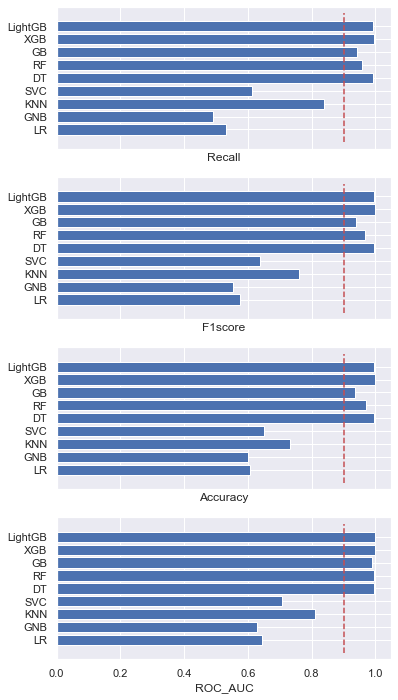

In [337]:
# plot barh plot to check the average score of recall, fscore, accuracy, roc_auc from cross validation
fig,axs = plt.subplots(4,1, figsize=(6,12),sharex=True)

axs[0].barh('model', 'test_recall', data=df_model_eval)
axs[1].barh('model', 'test_f1_score', data=df_model_eval)
axs[2].barh('model', 'test_accuracy', data=df_model_eval)
axs[3].barh('model', 'test_roc_auc',data=df_model_eval)

axs[0].set_xlabel('Recall')
axs[1].set_xlabel('F1score')
axs[2].set_xlabel('Accuracy')
axs[3].set_xlabel('ROC_AUC')


axs[0].plot([0.9,0.9],[-1,9],'r--')
axs[1].plot([0.9,0.9],[-1,9],'r--')
axs[2].plot([0.9,0.9],[-1,9],'r--')
axs[3].plot([0.9,0.9],[-1,9],'r--')
plt.show()

We will notice after re-training the same models based on the oversampled data (X_os_train, y_os_train) with 5folds cross validation, all the models are able to predict both classes.
Among 9 models, LightGB, XGB, GB, RF, DT overall have very good performance. (all metrics scores are higher than 0.9)

In the next step we will do two things:
<br> 1. plot five of the roc_auc test scores we got from the previous cross validation to check model variance (the less the better), 
<br> 2. plot the predicted probabily distribution to see how well the models are separating the two labels.

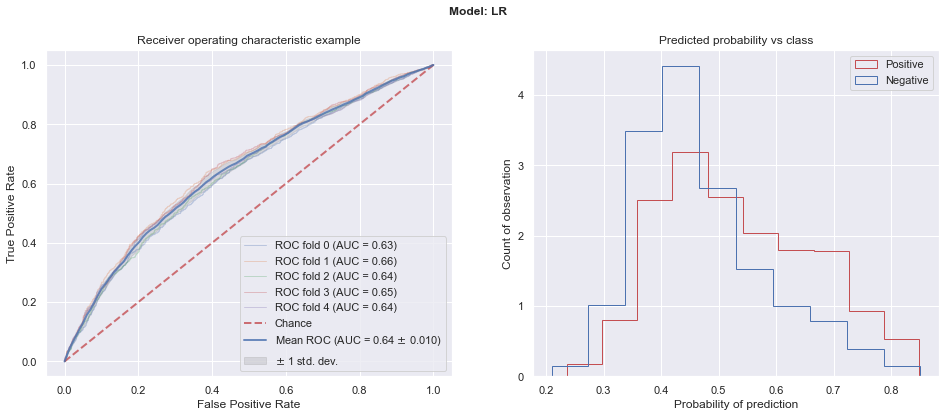

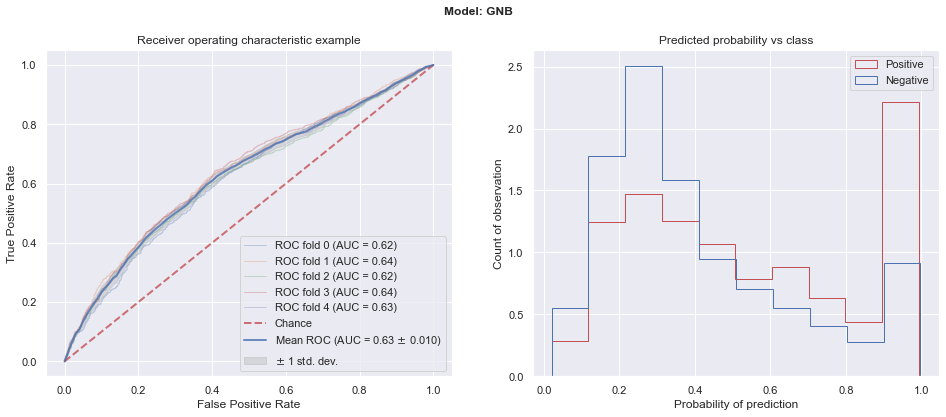

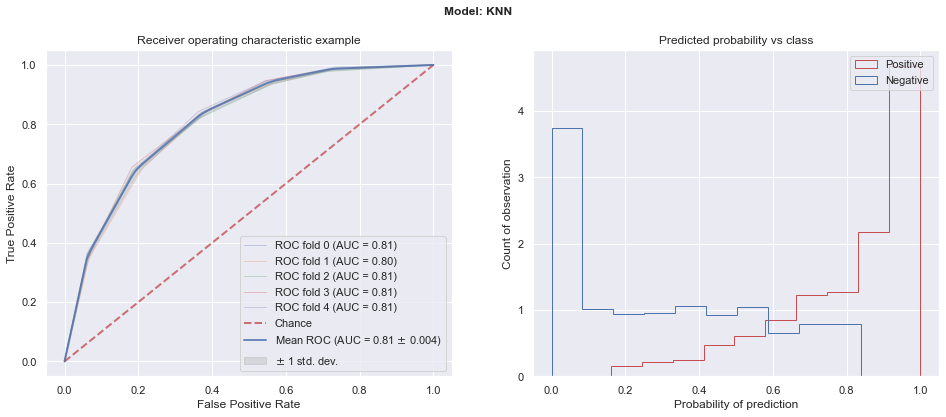

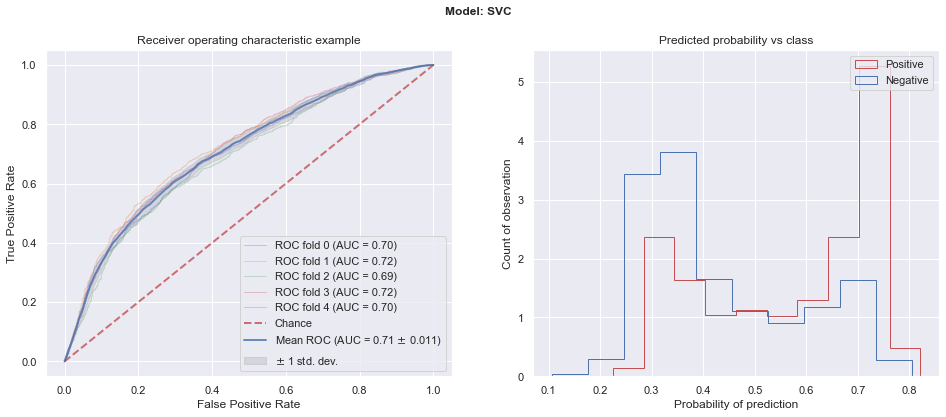

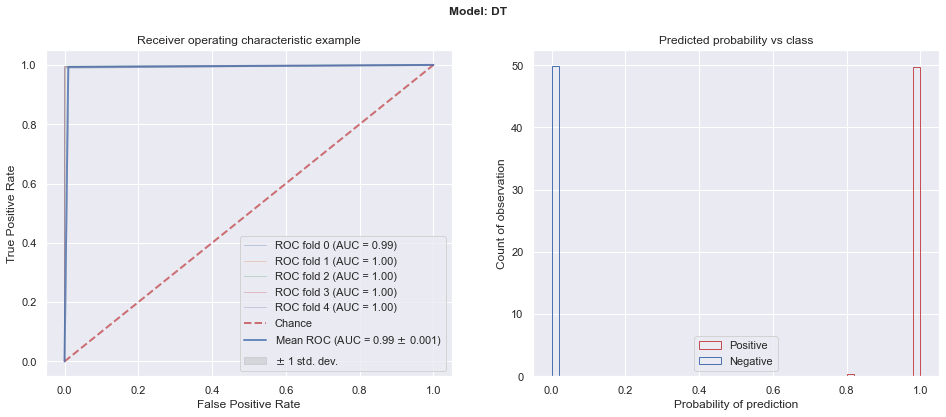

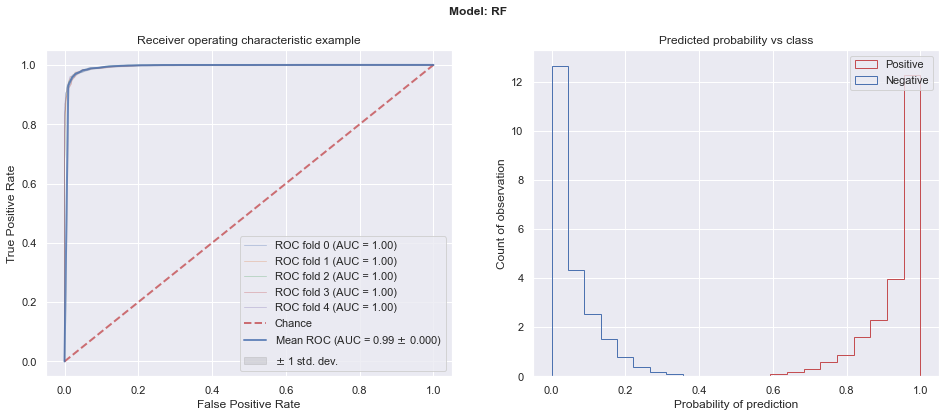

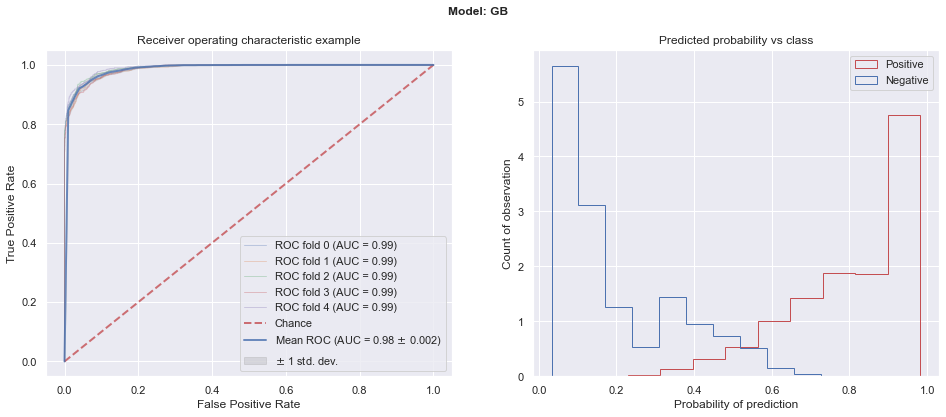

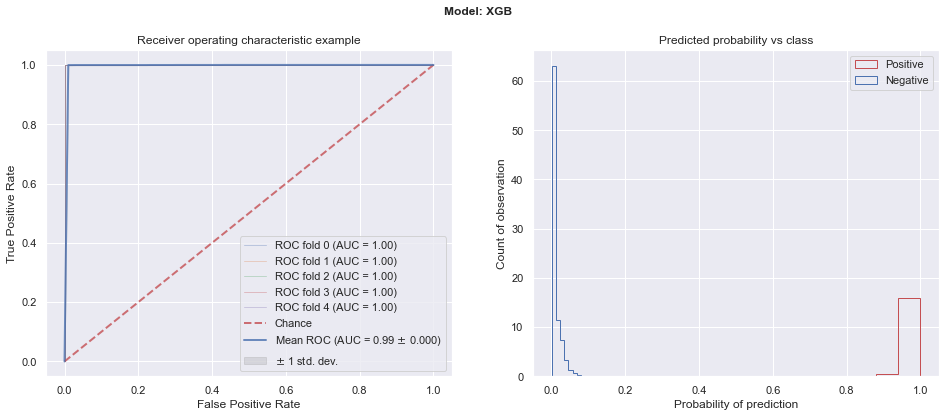

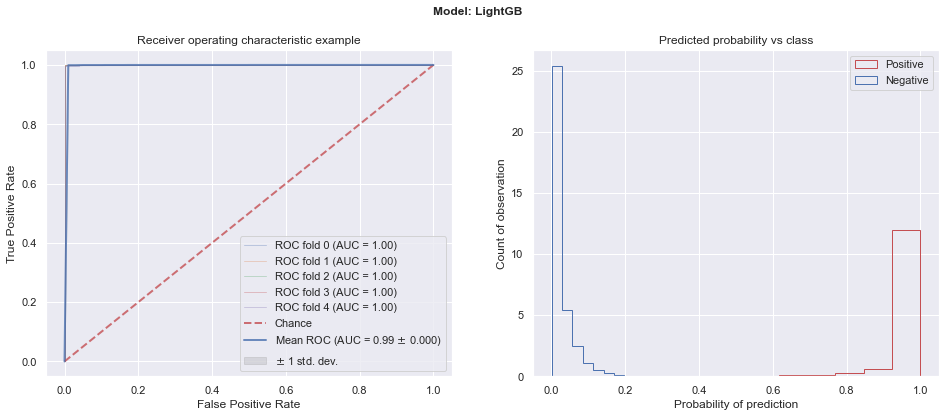

In [198]:
from sklearn.metrics import plot_roc_curve
cv = KFold(n_splits=5)

for index, model in model_dict.items():
    tprs = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)
    y_proba = []

    fig, (ax1,ax2) = plt.subplots(1,2)
    fig.set_size_inches(16,6)
    for i, (train, test) in enumerate(cv.split(X_os_train, y_os_train)):
        model.fit(X_os_train[train], y_os_train[train])
        y_proba.append(model.predict_proba(X_os_train)[:,1])
        viz = plot_roc_curve(model, X_os_train[test], y_os_train[test],
                         name='ROC fold {}'.format(i),
                         alpha=0.3, lw=1, ax=ax1)
        interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
        interp_tpr[0] = 0.0
        tprs.append(interp_tpr)
        aucs.append(viz.roc_auc)

    ax1.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
        label='Chance', alpha=.8)

    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    ax1.plot(mean_fpr, mean_tpr, color='b',
        label=r'Mean ROC (AUC = %0.2f $\pm$ %0.3f)' % (mean_auc, std_auc),
        lw=2, alpha=.8)

    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    ax1.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                label=r'$\pm$ 1 std. dev.')

    ax1.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05],
       title="Receiver operating characteristic example")
    ax1.legend(loc="lower right")

    
    
    predProba_label = pd.DataFrame()
    predProba_label['proba'] = pd.DataFrame(y_proba).mean()
    predProba_label['label'] = np.array(y_os_train)
    predProba_label.head()
    ax2.hist(predProba_label[predProba_label.label==1].proba, density=True, histtype='step',label='Positive',color='r')
    ax2.hist(predProba_label[predProba_label.label==0].proba, density=True, histtype='step',label='Negative')
    ax2.set_xlabel('Probability of prediction', fontsize=12)
    ax2.set_ylabel('Count of observation', fontsize=12)
    ax2.legend()
    ax2.set_title('Predicted probability vs class',fontsize=12)

    plt.suptitle(("Model: %s" % index),fontsize=12,fontweight='bold')

    plt.show()

After plotting out the ROC_AUC results and the predicted probability distribution,
we can easily tell 4 models overall are outperforming other models as they generate low variance, high recall (TPR) and separate the two classes with the least overlap. 
<br>These 4 models are: Decision Tree, Random Forest, XGB and LightGB.
However DT and RF tend to overfit on training data comparing to XGB and LightGB, therefore we will focus on LightGB and XGB in the next step to optimize their hyperparameters via BayesianOptimization. 

## Tune Hyperparameters for Outperformed Models (Bayesian Optimization)

In [200]:
from bayes_opt import BayesianOptimization

### Hyperparameter tuning for Lightgbm

In [231]:
# # create a function to tune hyperparameters for lightGB model and get test roc_auc score
# dataset: X_os_train, y_os_train
# crossvalidation: 3

def lgb_eval(learning_rate,num_leaves, max_depth, max_bin, subsample, colsample_bytree, min_child_samples, 
             min_child_weight, min_data_in_leaf, L2, L1):
    
    params = {
        "objective" : "binary",
        "is_unbalance": True,
        "learning_rate" : learning_rate,
        "num_leaves" : int(num_leaves),
        "max_depth" : int(max_depth),
        "max_bin" : int(max_bin),
        "subsample" : subsample,
        "colsample_bytree" : colsample_bytree,
        "min_child_samples" : int(min_child_samples),
        "min_child_weight" : int(min_child_weight),
        "min_data_in_leaf" : int(min_data_in_leaf),
        "reg_lambda" : L2,
        "reg_alpha" : L1,
        "num_threads" : 20,
        "subsample_freq" : 5,
        "random_state" : 43,
        "verbose": -1
      
    }
    lgtrain = lgb.Dataset(X_os_train, y_os_train)
   
    cv_result = lgb.cv(params,
                       lgtrain,
                       num_boost_round = 1000,
                       metrics='auc',
                       early_stopping_rounds=100,
                       stratified=True,
                       nfold=3)
    
    return cv_result['auc-mean'][-1]

In [232]:
# create a function to perform BayesianOptimization to search for the best hyperparameters
lgbBO = BayesianOptimization(lgb_eval, {'learning_rate': (0.001, 0.4),
                                        'num_leaves': (25, 4000),
                                        'max_depth': (0, 100),
                                        'max_bin': (1,1000),
                                        'subsample': (0.5, 1),
                                        'colsample_bytree': (0.4,1),
                                        'min_child_samples': (50, 10000),
                                        'min_child_weight' : (0, 0.05),
                                        'min_data_in_leaf': (10, 2000),
                                        'L2': (0.0, 100),
                                        'L1': (0.0, 1)})

lgbBO.maximize(n_iter=10, init_points=2)

|   iter    |  target   |    L1     |    L2     | colsam... | learni... |  max_bin  | max_depth | min_ch... | min_ch... | min_da... | num_le... | subsample |
-------------------------------------------------------------------------------------------------------------------------------------------------------------
|  1        |  0.9731   |  0.1576   |  94.6     |  0.702    |  0.1282   |  518.9    |  42.88    |  1.142e+0 |  0.04566  |  1.001e+0 |  1.15e+03 |  0.7753   |
|  2        |  0.8391   |  0.5635   |  3.18     |  0.5989   |  0.1286   |  828.6    |  32.49    |  7.71e+03 |  0.01504  |  1.982e+0 |  2.051e+0 |  0.534    |
|  3        |  0.9738   |  0.5069   |  52.56    |  0.4848   |  0.2462   |  393.7    |  37.24    |  6.683e+0 |  0.03061  |  1.406e+0 |  198.0    |  0.9268   |
|  4        |  0.9893   |  0.3814   |  25.49    |  0.9906   |  0.1225   |  983.9    |  80.3     |  1.139e+0 |  0.00982  |  613.9    |  3.965e+0 |  0.9217   |
|  5        |  0.9395   |  0.129    |  68.04    |  0

In [233]:
lgbBO.max

{'target': 0.9995555776088206,
 'params': {'L1': 0.07304537480007933,
  'L2': 96.7623980611062,
  'colsample_bytree': 0.5165146986204654,
  'learning_rate': 0.38769382642059513,
  'max_bin': 569.4351554898769,
  'max_depth': 64.3103154779128,
  'min_child_samples': 112.90785943134989,
  'min_child_weight': 0.0027438115545873223,
  'min_data_in_leaf': 57.914507748529985,
  'num_leaves': 2876.177316119405,
  'subsample': 0.517782219295734}}

In [269]:
# use model_eval function to test result of LGB model with tuned hyperparameter
# dataset: X_os_test, y_os_test with crossvalidation(5)

tuned_lgb = model_eval(lgb.LGBMClassifier
           (objective='binary', 
            L1=0.07,
            L2=97,
            colsample_bytree=0.517,
            learning_rate= 0.388,
            max_bin = 569,
            max_depth = 64,
            min_child_samples= 112,
            min_child_weight= 0.003,
            min_data_in_leaf= 58,
            num_leaves= 2876,
            subsample= 0.518,
            verbose=-1,
            random_state=43),
            X_os_test,y_os_test).mean()

tuned_lgb

fit_time          0.1966
score_time        0.0174
test_accuracy     0.9880
test_precision    0.9958
test_recall       0.9798
test_f1_score     0.9878
test_roc_auc      0.9990
dtype: float64

In [271]:
# test result of LGB model with default value 
# dataset: X_os_test, y_os_test with crossvalidation(5)

default_lgb = model_eval(lgb.LGBMClassifier(objective='binary',random_state=43),
           X_os_test,y_os_test).mean()

default_lgb

fit_time          0.0912
score_time        0.0146
test_accuracy     0.9856
test_precision    0.9924
test_recall       0.9784
test_f1_score     0.9854
test_roc_auc      0.9988
dtype: float64

### Hyperparameter tuning for XGB

In [236]:
# create a function to tune hyperparameters for XGB model and get test roc_auc score
# dataset: X_os_train, y_os_train
# crossvalidation: 3

def XGB_eval(eta, gamma, colsample_bytree, max_depth, min_child_weight, L2):
    params = {
        "objective" : "binary:logistic",
        "eta" : eta,
        "gamma" : gamma,
        "subsample" : 0.5,
        "colsample_bytree" : colsample_bytree,
        "max_depth" : int(max_depth),
        "min_child_weight" : int(min_child_weight),
        "lambda" : L2,
        #"alpha" : L1,
        "seed" : 43,
        "nthread": 4}
    
    
    xgtrain = xgb.DMatrix(X_os_train, label=y_os_train)
    cv_result =xgb.cv(params,
                      xgtrain,
                      early_stopping_rounds=100,
                      num_boost_round=70,
                      stratified=True,
                      nfold=3,
                      metrics= 'auc')
                       
          
    return cv_result['test-auc-mean'].iloc[-1]

In [238]:
# create a function to perform BayesianOptimization to search for the best hyperparameters
xgbBO = BayesianOptimization(XGB_eval, {'eta': (0.001,0.4),
                                        'gamma': (0,20),
                                        #'subsample': (0.5,1),
                                        'colsample_bytree': (0,1),
                                        'max_depth': (1, 10),
                                        'min_child_weight': (0,20),
                                        'L2':(0, 100)
                                        #'L1': (0, 1),
                                        })
                                        
                                        

xgbBO.maximize(n_iter=10, init_points=2)

|   iter    |  target   |    L2     | colsam... |    eta    |   gamma   | max_depth | min_ch... |
-------------------------------------------------------------------------------------------------
|  1        |  0.747    |  66.19    |  0.8978   |  0.03541  |  11.99    |  1.253    |  2.925    |
|  2        |  0.9249   |  52.31    |  0.1106   |  0.1019   |  8.669    |  5.094    |  19.35    |
|  3        |  0.927    |  53.01    |  0.3741   |  0.05074  |  8.845    |  4.964    |  17.78    |
|  4        |  0.9509   |  38.3     |  1.0      |  0.001    |  5.467    |  10.0     |  11.12    |
|  5        |  0.6323   |  31.95    |  1.0      |  0.001    |  20.0     |  1.0      |  14.15    |
|  6        |  0.9828   |  48.41    |  0.0      |  0.4      |  0.0      |  10.0     |  11.27    |
|  7        |  0.9881   |  38.89    |  0.0      |  0.4      |  0.0      |  10.0     |  0.0      |
|  8        |  0.9984   |  0.0      |  0.0      |  0.4      |  0.0      |  10.0     |  0.0      |
|  9        |  0.985

In [239]:
xgbBO.max

{'target': 0.9996010000000001,
 'params': {'L2': 17.876683563886523,
  'colsample_bytree': 1.0,
  'eta': 0.4,
  'gamma': 0.0,
  'max_depth': 10.0,
  'min_child_weight': 0.0}}

In [270]:
# use model_eval function to test result of XGB model with tuned hyperparameter
# dataset: X_os_test, y_os_test with crossvalidation(5)

tuned_xgb = model_eval(XGBClassifier
           (#L1=0.318,
            #L2=17,
            objective='binary:logistic',
            colsample_bytree=1,
            gamma=0,
            eta= 0.4,
            max_depth = 10,
            min_child_weight=0,
            subsample=1,
            seed=43),
            X_os_test,y_os_test).mean()

tuned_xgb

fit_time          0.2764
score_time        0.0094
test_accuracy     0.9956
test_precision    0.9988
test_recall       0.9920
test_f1_score     0.9954
test_roc_auc      0.9998
dtype: float64

In [272]:
# test result of XGB model with default parameter values
# dataset: X_os_test, y_os_test with crossvalidation(5)

default_xgb = model_eval(XGBClassifier(
            objective='binary:logistic',
            seed=43),
            X_os_test,y_os_test).mean()

default_xgb

fit_time          0.1734
score_time        0.0072
test_accuracy     0.9934
test_precision    0.9988
test_recall       0.9880
test_f1_score     0.9932
test_roc_auc      0.9998
dtype: float64

In [305]:
LGB = [default_lgb[4], tuned_lgb[4], tuned_lgb[0],tuned_lgb[1]]
XGB = [default_xgb[4], tuned_xgb[4], tuned_xgb[0],tuned_xgb[1]]
comb = [LGB, XGB]

# create a dataframe to compare recall between default lgb, tune lgb, default xgb, tune xgb.
# compare fit time, score time between lgb tuned model and xgb tuned model. 
pd.DataFrame(comb, index=['LGB','XGB'], columns=['Recall_default', 'Recall_tuned', 'fit_time (tuned)', 'score_time (tuned)'])


,Recall_default,Recall_tuned,fit_time,score_time
LGB,0.9784,0.9798,0.1966,0.0174
XGB,0.9880,0.9920,0.2764,0.0094


From above we can see model LightGB and model XGB both had a small boost in Recall after we tuned the hyperparameters.
<br>Considering XGB performs slight better than LGB in terms of Recall and needs less time to predict, <br>we will choose XGB as the final model and will test it on our final test set: <b>X_test</b>, <b>y_test</b>.

## Final model

In [314]:
# final test of XBG model with tuned hyperparameters on X_test, y_test without crossvalidation.
# dataset: X_test, y_test

final_xgb = XGBClassifier(objective='binary:logistic',
            colsample_bytree=1,
            gamma=0,
            eta= 0.4,
            max_depth = 10,
            min_child_weight=0,
            subsample=1,
            seed=43)

start = time.time()
final_xgb.fit(X_os_train,y_os_train)
end = time.time()
fit_time = end - start

start = time.time()
y_pred = final_xgb.predict(X_test)
end = time.time()
pred_time = end - start

# get precision, recall, fscore.
print(score(y_test, y_pred, pos_label=1,average='binary'))
print(fit_time)
print(pred_time)

(1.0, 1.0, 1.0, None)
0.7384190559387207
0.008543968200683594


In [254]:
(y_pred==y_test).value_counts()

True    5508
Name: target, dtype: int64

In [313]:
# final test of LGB model with tuned hyperparameters on X_test, y_test without crossvalidation.
# dataset :X_test, y_test

final_lgb = lgb.LGBMClassifier(objective='binary', 
            L1=0.07,
            L2=97,
            colsample_bytree=0.5,
            learning_rate= 0.4,
            max_bin = 569,
            max_depth = 64,
            min_child_samples= 112,
            min_child_weight= 0.003,
            min_data_in_leaf= 58,
            num_leaves= 2876,
            subsample= 0.5,
            verbose=-1,
            random_state=43)

start = time.time()
final_lgb.fit(X_os_train,y_os_train)
end = time.time()
fit_time = end - start

start = time.time()
y_pred = final_lgb.predict(X_test)
end = time.time()

pred_time = end - start

# get precision, recall, fscore.
print(score(y_test, y_pred, pos_label=1,average='binary'))
print(fit_time)
print(pred_time)

(0.9986187845303868, 0.9931318681318682, 0.9958677685950413, None)
0.44736194610595703
0.02673625946044922


In [312]:
(y_pred==y_test).value_counts()

True     5502
False       6
Name: target, dtype: int64

In [215]:
## Hyperparameter tuning for RF

In [216]:
# from sklearn.model_selection import cross_val_score

In [217]:
# def rf_cv(X, y, **kwargs):
#     estimator = RandomForestClassifier(**kwargs)
#     cval = cross_val_score(estimator, X, y, scoring = 'roc_auc', cv = 3)
#     #cval = cross_val_score(estimator, X_train, y_train, scoring = 'roc_auc', cv = 3)
#     return cval.mean()


# def BayesianOptimization_rf(X, y):
#     def rf_crossval(n_estimators,  max_depth, 
#                     min_samples_split, max_leaf_nodes, min_samples_leaf,random_state=43):
        
#         return rf_cv(
#             X = X,
#             y = y,
#             bootstrap = True)
    
#     rfBO = BayesianOptimization(
#         f = rf_crossval,
#         pbounds = {
#             "n_estimators" : (10, 400),
#             #"max_features" : 
#             "max_depth" : (0,50),
#             "min_samples_split" : (0,5000),
#             "max_leaf_nodes" : (0,200),
#             "min_samples_leaf" : (0,0.5)
#         }
#     )
#     rfBO.maximize(n_iter = 10,init_points=2)
#     print("Final result:", rfBO.max)

In [218]:
#BayesianOptimization_rf(X_os_train,y_os_train)

In [219]:
# model = RandomForestClassifier(max_depth=6.24, 
#                                max_leaf_nodes=157, min_samples_leaf=0.075,
#                                min_samples_split=2216,random_state=43)

In [220]:
## Hyperparameter tuning for LogisticRegression

In [221]:
# def lr_cv(X, y, **kwargs):
#     estimator = LogisticRegression(**kwargs)
#     cval = cross_val_score(estimator, X, y, scoring = 'recall', cv = 3)
#     return cval.mean()


# def BayesianOptimization_lr(X, y):
#     def lr_crossval(C):
        
#         return rf_cv(
#             X = X,
#             y = y)
    
#     lrBO = BayesianOptimization(
#         f = lr_crossval,
#         pbounds = {
#             "C" : (0, 1000)
#             #"l2" : (0,100)
#         }
#     )
#     lrBO.maximize(n_iter = 10,init_points=2)
#     print("Final result:", lrBO.max)

In [222]:
#BayesianOptimization_lr(X_os_train,y_os_train)

As we can see lightgb and xgb both perform very well, and their scores are really close.
We choose to use lightgb as the final model, as the data fit time for lgb is 8 times faster than xgb while predict times are both around less than 0.02s.

In [223]:
fin_model =lgb.LGBMClassifier(objective='binary', 
            L1=0.214,
            L2=49,
            colsample_bytree=0.426,
            learning_rate= 0.346,
            max_depth = 10,
            min_child_samples= 4977,
            min_child_weight= 0.036,
            min_data_in_leaf= 28,
            num_leaves=49,
            subsample= 0.567,
            verbose=-1,
            random_state=43)

fin_model.fit(X_os_train, y_os_train)
fin_y_pred = fin_model.predict(X_test)

# get precision, recall, fscore
score(y_test, fin_y_pred, pos_label=1,average='binary')    

(0.9986206896551724, 0.9945054945054945, 0.9965588437715072, None)

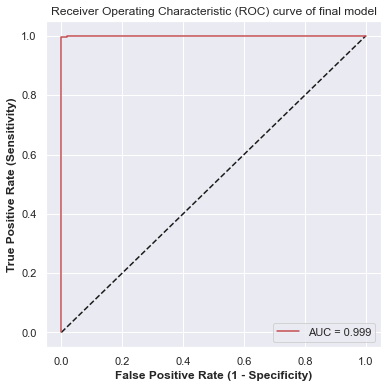

In [224]:
lgb_fpr,lgb_tpr,threshold = roc_curve(y_test,fin_model.predict_proba(X_test)[:,1])
roc_auc_ = metrics.auc(lgb_fpr,lgb_tpr)
plt.figure(figsize=(6,6))
_=plt.plot([0,1],[0,1],'k--')
_=plt.plot(lgb_fpr,lgb_tpr,'r',label='AUC = %.3f'%roc_auc_)
_=plt.title('Receiver Operating Characteristic (ROC) curve of final model')
_=plt.xlabel('False Positive Rate (1 - Specificity)',fontsize=12,fontweight='bold')
_=plt.ylabel('True Positive Rate (Sensitivity)',fontsize=12,fontweight='bold')
_=plt.legend(loc='lower right')

#plt.savefig('figures/roc.jpg', dpi=300, bbox_inches='tight')

In [225]:
(fin_y_pred == y_test).value_counts()

True     5503
False       5
Name: target, dtype: int64

In [226]:
metrics.confusion_matrix(y_test, y_pred,labels=[1,0])

array([[ 728,    0],
       [   0, 4780]])